In [1]:
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from arch import arch_model
import requests
import statsmodels.api as sm
from scipy.signal import detrend
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch import arch_model
from datetime import datetime
from datetime import datetime, timedelta


from itertools import product

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

YF.download() has changed argument auto_adjust default to True


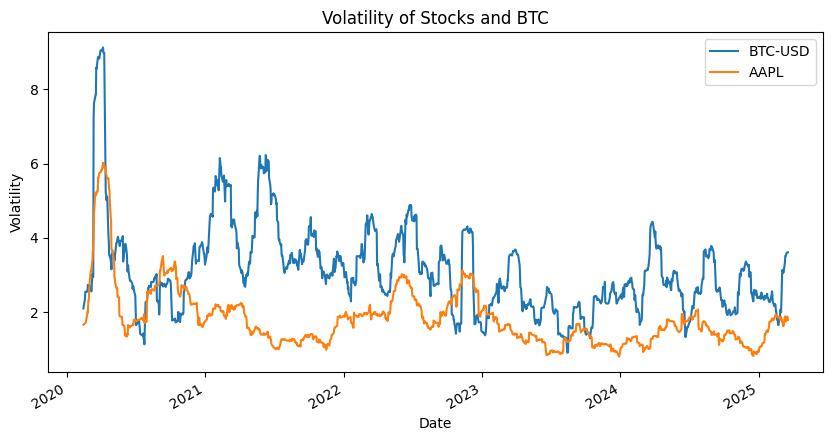

C:\Users\kubus\AppData\Local\Temp\ipykernel_18880\2270715379.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prices_df = prices_df.resample('M').mean()  # Monthly average closing price
C:\Users\kubus\AppData\Local\Temp\ipykernel_18880\2270715379.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns_df.resample('M').sum()  # Monthly total return
C:\Users\kubus\AppData\Local\Temp\ipykernel_18880\2270715379.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volatility = volatility_df.resample('M').std()  # Monthly volatility


In [ ]:
tickers = ['BTC-USD', 'AAPL']


volatility_data = {}
returns_data = {}
prices_data = {}
for ticker in tickers:   
    data = yf.download(ticker, start='2020-01-01', end=datetime.today().strftime("%Y-%m-%d"), progress=False)
    data["daily return"] = data["Close"].pct_change() * 100
    data["volatility"] = data["daily return"].rolling(window=30).std()
    volatility_data[ticker] = data["volatility"]
    returns_data[ticker] = data["daily return"]
    prices_data[ticker] = data["Close"]
    

    
volatility_df = pd.concat(volatility_data, axis=1)
volatility_df.dropna(inplace=True)

returns_df = pd.concat(returns_data, axis=1)
returns_df.dropna(inplace=True)


prices_df = pd.concat(prices_data, axis=1)
prices_df.dropna(inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
volatility_df.plot(ax=ax)
plt.title("Volatility of Stocks and BTC")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.show()

prices_df = prices_df.resample('M').mean()  
monthly_returns = returns_df.resample('M').sum()  
monthly_volatility = volatility_df.resample('M').std()  y
        



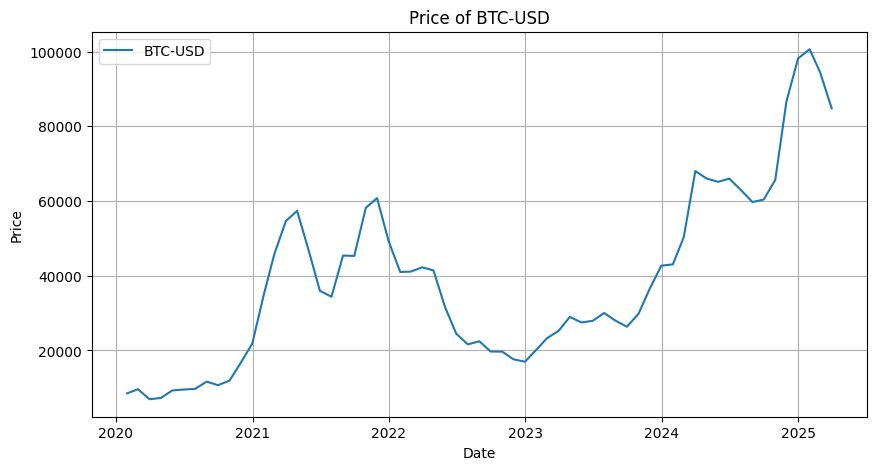

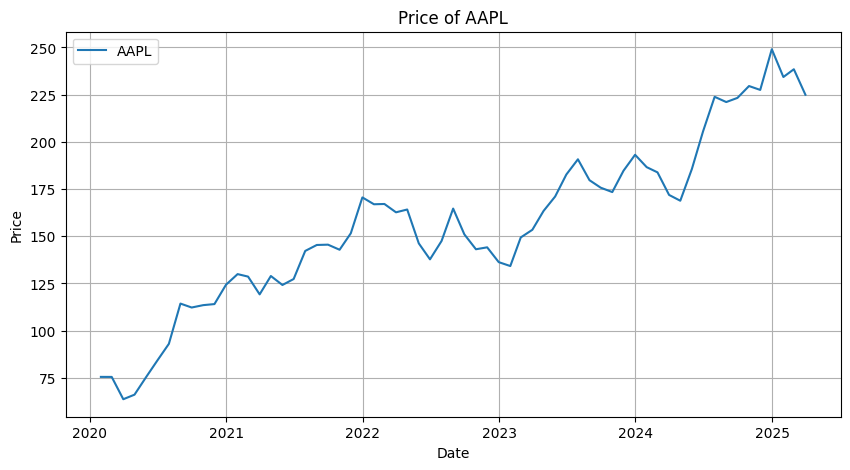

In [19]:
for ticker in tickers:
    plt.figure(figsize=(10, 5))
    plt.plot(prices_df[ticker], label=ticker)
    plt.title(f"Price of {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
def adf_test(series):
    result = adfuller(series.dropna())  
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    
    if result[1] < 0.05:
        print("The series is stationary (Reject H0)")
    else:
        print("The series is non-stationary (Fail to reject H0)")



for ticker in tickers:
    adf_test(prices_df[ticker])

ADF Statistic: -1.7983925395197293
p-value: 0.3812600446650283
Critical Values: {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
The series is non-stationary (Fail to reject H0)
ADF Statistic: -1.124502736166111
p-value: 0.7052022520710239
Critical Values: {'1%': -3.540522678829176, '5%': -2.9094272025108254, '10%': -2.5923136524453696}
The series is non-stationary (Fail to reject H0)


<Axes: xlabel='Date'>

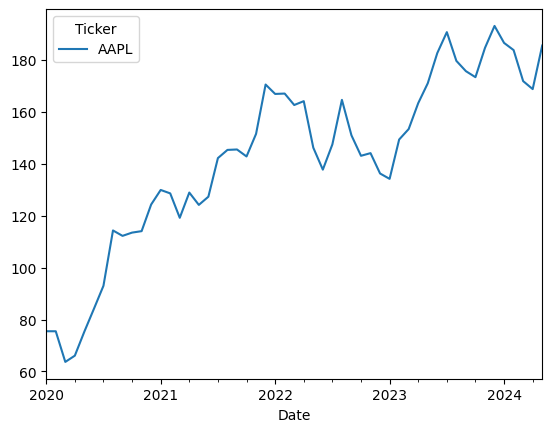

In [21]:
df_train = {}
df_test = {}
for ticker in tickers:
    cutoff = int(len(prices_df[ticker]) - 10)
    df_train[ticker] = prices_df[ticker][:cutoff]
    df_test[ticker] = prices_df[ticker][cutoff:]


df_train["AAPL"].plot()

In [ ]:

Q = range(0,3)
q = range(0,3)
P = range(0,3)
p = range(0,3)
d = 1
D = 1

params = product(p, q, P, Q)
param_list = list(params)
len(param_list)
results = []
best_models = {}


for ticker in tickers:
    best_model = None
    best_param = None
    best_aic = float('inf')  

    for param in param_list:
        try:
            model = SARIMAX(
                df_train[ticker], 
                order=(param[0], d, param[1]), 
            
                seasonal_order=(param[2], D, param[3], 12)
            ).fit(disp=-1)

        except Exception as e:
            print(f'Error with parameters {param} for {ticker}: {e}')
            continue

        aic = model.aic

        
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param

        results.append([ticker, param, aic])

    best_models[ticker] = {'model': best_model, 'param': best_param, 'aic': best_aic}





c:\Users\kubus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\kubus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\kubus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\kubus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmod

In [23]:
fitted_models = {}  
summaries = {} 
residuals = {}
for ticker in tickers:
    best_param = best_models[ticker]['param']
    order = (best_param[0], d, best_param[1])
    seasonal_order = (best_param[2], D, best_param[3], 12)
    model1 =  SARIMAX(df_train[ticker], order=order, seasonal_order=seasonal_order).fit(disp=-1)
    model1.summary()
    fitted_models[ticker] = model1
    summaries[ticker] = model1.summary()
    residuals[ticker] = model1.resid
    



c:\Users\kubus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


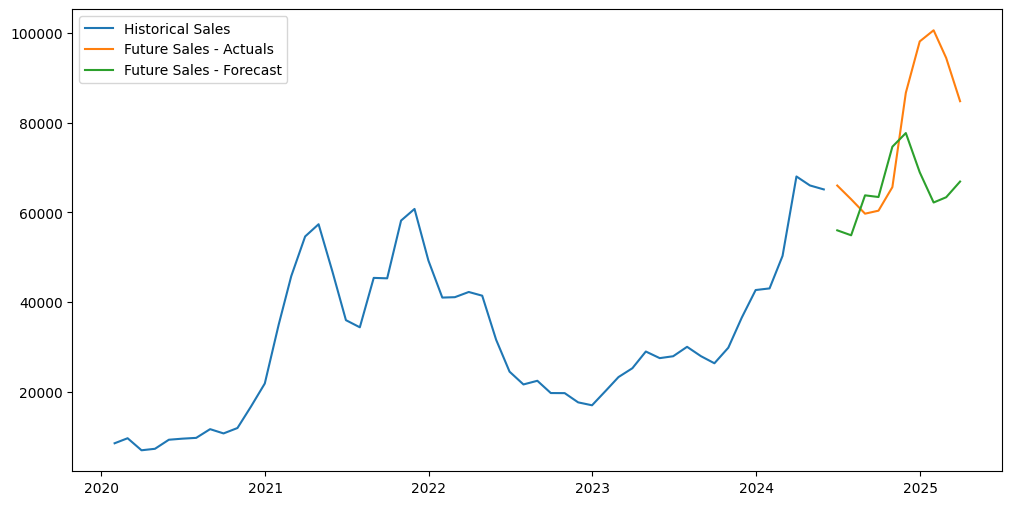

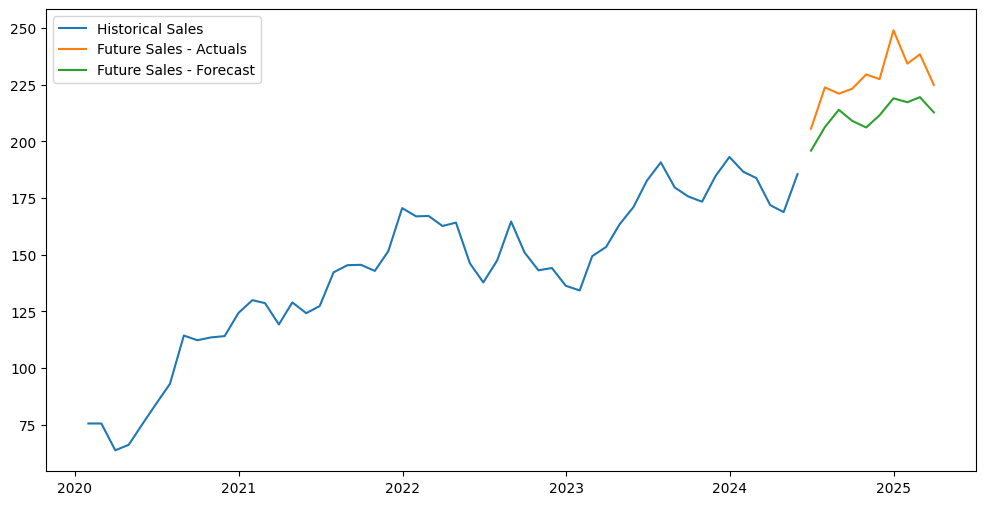

In [24]:
for ticker in tickers:
    
    forecast = fitted_models[ticker].forecast(len(df_test[ticker]))
    plt.figure(figsize = (12, 6))
    plt.plot(df_train[ticker].index, df_train[ticker], label='Historical Sales')
    plt.plot(df_test[ticker].index, df_test[ticker], label='Future Sales - Actuals')
    plt.plot(df_test[ticker].index, forecast, label='Future Sales - Forecast')
    plt.legend()
    plt.show()